# 0. Load File

In [13]:
import pandas as pd

df_auto = pd.read_pickle('../data/processed/df_auto.pkl')

df_auto.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16891 entries, 0 to 16890
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   title               16891 non-null  object  
 1   year                16891 non-null  int64   
 2   km                  16891 non-null  float64 
 3   fuelTypeId          16825 non-null  object  
 4   fuelType            16825 non-null  object  
 5   isProfessional      16891 non-null  object  
 6   mainProvince        16890 non-null  object  
 7   hasWarranty         16891 non-null  object  
 8   warrantyMonths      16891 non-null  object  
 9   includesTaxes       16891 non-null  object  
 10  price               16891 non-null  int64   
 11  brand_model         16891 non-null  object  
 12  kw                  10153 non-null  float64 
 13  cv                  16891 non-null  float64 
 14  km_range            16888 non-null  category
 15  cv_range            16891 non-null  

# 1. Feature Selection

Selected features for modeling:
- **km**: Mileage - key depreciation factor
- **fuelType**: Gasoline, Diesel, Electric, Hybrid
- **cv**: Engine power (horsepower)
- **age**: Vehicle age in years
- **brand**: Car manufacturer
- **segment**: Vehicle class (A, B, C, D, etc.)
- **body_type**: Body style (sedan, SUV, hatchback, etc.)
- **price_calc**: Target variable - calculated price

**Excluded features**:
- `isProfessional`: Professional seller flag
- `warrantyMonths`: Warranty duration
These were removed to simplify the initial model. Can be added back for comparison.

In [14]:
# Select features for modeling
df = df_auto[["km", "fuelType", "cv", "age", "brand", "segment", "body_type", "price_calc"]]

print(f"Dataset shape: {df.shape}")
df.dtypes

Dataset shape: (16891, 8)


km            float64
fuelType       object
cv            float64
age             int64
brand          object
segment        object
body_type      object
price_calc      int64
dtype: object

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16891 entries, 0 to 16890
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   km          16891 non-null  float64
 1   fuelType    16825 non-null  object 
 2   cv          16891 non-null  float64
 3   age         16891 non-null  int64  
 4   brand       16891 non-null  object 
 5   segment     16891 non-null  object 
 6   body_type   16891 non-null  object 
 7   price_calc  16891 non-null  int64  
dtypes: float64(2), int64(2), object(4)
memory usage: 1.0+ MB


In [16]:
# Correlation with target for numerical features
import numpy as np

numeric_cols = df.select_dtypes(include=[np.number]).columns
correlations = df[numeric_cols].corr()['price_calc'].sort_values(ascending=False)
print("Correlation with price_calc:")
print(correlations)

Correlation with price_calc:
price_calc    1.000000
cv            0.173312
age          -0.120835
km           -0.228178
Name: price_calc, dtype: float64


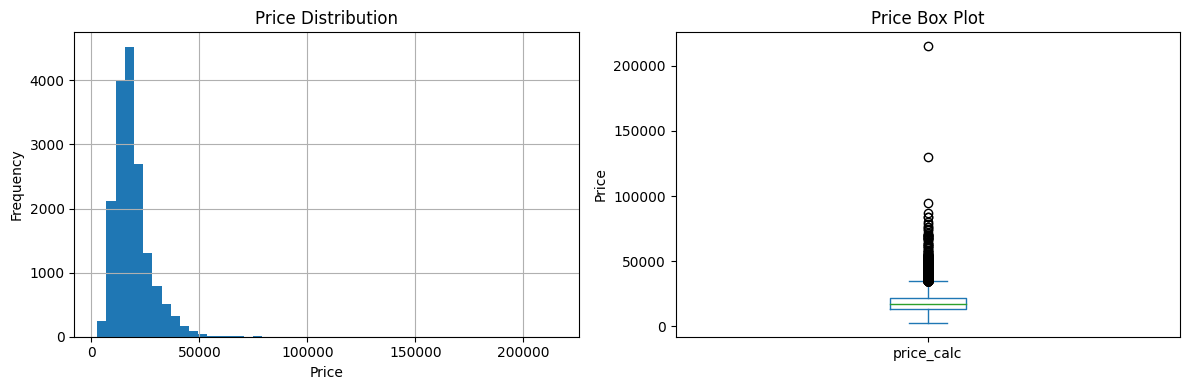

Price stats: Mean=18816.24, Median=17165.00, Std=8455.03


In [17]:
# Target variable distribution
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
df['price_calc'].hist(bins=50, ax=axes[0])
axes[0].set_title('Price Distribution')
axes[0].set_xlabel('Price')
axes[0].set_ylabel('Frequency')

df['price_calc'].plot(kind='box', ax=axes[1])
axes[1].set_title('Price Box Plot')
axes[1].set_ylabel('Price')
plt.tight_layout()
plt.show()

print(f"Price stats: Mean={df['price_calc'].mean():.2f}, Median={df['price_calc'].median():.2f}, Std={df['price_calc'].std():.2f}")

In [18]:
# Check for missing values
missing = df.isnull().sum()
print("Missing values per column:")
print(missing[missing > 0])
print(f"\nTotal missing: {missing.sum()}")

Missing values per column:
fuelType    66
dtype: int64

Total missing: 66


In [19]:
# Summary statistics
df.describe()

,km,cv,age,price_calc
count,1.689100e+04,16891.000000,16891.000000,16891.000000
mean,7.396977e+04,86.511288,4.641229,18816.238411
std,9.428250e+04,66.637377,2.657517,8455.033888
min,1.000000e+00,0.000000,0.000000,2700.000000
25%,3.160300e+04,0.000000,3.000000,13450.000000
50%,6.400000e+04,100.000000,5.000000,17165.000000
75%,1.004450e+05,128.000000,6.000000,21990.000000
max,9.999999e+06,399.840000,11.000000,215000.000000


# 2. Exploratory Data Analysis (EDA)

# 3. Auto ML - PyCaret

**References:**
- [PyCaret Regression Tutorial](https://colab.research.google.com/github/pycaret/pycaret/blob/master/tutorials/Tutorial%20-%20Regression.ipynb#scrollTo=8116e19d)
- [PyCaret Regression Documentation](https://www.pycaret.org/tutorials/html/REG101.html)

## 3.1 Setup Experiment

PyCaret's `setup()` automatically handles:
- Train/test split (default 70/30)
- Data preprocessing and transformation
- Categorical encoding
- Feature engineering

In [20]:
from pycaret.regression import (
    setup, compare_models, tune_model, plot_model, 
    interpret_model, finalize_model, predict_model, 
    pull, save_model
)

# Initialize regression experiment
s = setup(
    df, 
    target='price_calc', 
    max_encoding_ohe=60,  # Max categories for one-hot encoding
    session_id=42,  # For reproducibility
    verbose=False
)

## 3.2 Compare Models

Compare baseline models using cross-validation.

In [21]:
# Compare all baseline models (uses 10-fold CV by default)
best = compare_models()

# Get comparison results as dataframe
results = pull()
print("\nBest Model:", type(best).__name__)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,2515.9592,18032504.3058,4157.1489,0.7620,0.1865,0.1411,0.1280
gbr,Gradient Boosting Regressor,2601.6041,18996648.9799,4272.3602,0.7488,0.1919,0.1466,0.1590
rf,Random Forest Regressor,2587.3888,19436153.8717,4332.4582,0.7418,0.1933,0.1445,0.5420
et,Extra Trees Regressor,2730.4280,22290161.9225,4655.4142,0.7008,0.2053,0.1523,0.3950
dt,Decision Tree Regressor,3337.0747,33692501.8788,5735.2167,0.5437,0.2534,0.1847,0.0330
knn,K Neighbors Regressor,5173.1209,58157422.8031,7599.3626,0.2070,0.3560,0.2893,0.0350
lr,Linear Regression,3576.1160,64075237.7629,6793.5841,0.0869,0.2641,0.2148,0.4990
ridge,Ridge Regression,3575.7080,64073515.8423,6793.4890,0.0869,0.2642,0.2148,0.0270
br,Bayesian Ridge,3575.4236,64072846.7211,6793.4609,0.0869,0.2642,0.2148,0.0340
lasso,Lasso Regression,3574.8488,64092161.8857,6793.8885,0.0866,0.2641,0.2147,0.2650



Best Model: LGBMRegressor


In [22]:
# Hyperparameter tuning
tuned_best = tune_model(best, n_iter=50)

# Compare before and after tuning
tuning_results = pull()
print("\nTuned Model Results:")
print(tuning_results)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2538.3254,44734118.4792,6688.3569,0.5576,0.1933,0.1370
1,2512.0154,15838788.0061,3979.7975,0.7846,0.1967,0.1494
2,2415.5313,17873764.0797,4227.7375,0.7646,0.1772,0.1347
3,2491.6243,13724278.4914,3704.6293,0.8072,0.1815,0.1407
4,2505.2256,13806378.0825,3715.6935,0.7870,0.1836,0.1415
5,2561.3998,13857942.0671,3722.6257,0.7894,0.1834,0.1422
6,2655.1343,17810091.1870,4220.2004,0.7542,0.1963,0.1476
7,2519.6144,13979707.7310,3738.9447,0.7980,0.1864,0.1424
8,2337.2200,12434912.5387,3526.3171,0.8203,0.1771,0.1329


Fitting 10 folds for each of 50 candidates, totalling 500 fits

Tuned Model Results:
            MAE           MSE       RMSE      R2   RMSLE    MAPE
Fold                                                            
0     2538.3254  4.473412e+07  6688.3569  0.5576  0.1933  0.1370
1     2512.0154  1.583879e+07  3979.7975  0.7846  0.1967  0.1494
2     2415.5313  1.787376e+07  4227.7375  0.7646  0.1772  0.1347
3     2491.6243  1.372428e+07  3704.6293  0.8072  0.1815  0.1407
4     2505.2256  1.380638e+07  3715.6935  0.7870  0.1836  0.1415
5     2561.3998  1.385794e+07  3722.6257  0.7894  0.1834  0.1422
6     2655.1343  1.781009e+07  4220.2004  0.7542  0.1963  0.1476
7     2519.6144  1.397971e+07  3738.9447  0.7980  0.1864  0.1424
8     2337.2200  1.243491e+07  3526.3171  0.8203  0.1771  0.1329
9     2413.8653  1.461644e+07  3823.1453  0.7818  0.1767  0.1322
Mean  2494.9956  1.786764e+07  4134.7448  0.7645  0.1852  0.1401
Std     84.1029  9.115191e+06   878.3664  0.0713  0.0074  0.0055


# 4. Model Interpretation & Evaluation

## 4.2 Diagnostic Plots

In [23]:
# Use tuned model if available, otherwise use best
final_model = tuned_best if 'tuned_best' in locals() else best

# Display key metrics
from pycaret.regression import pull
metrics_df = pull()
print("Model Performance Metrics:")
print(metrics_df.iloc[0])

Model Performance Metrics:
MAE      2.538325e+03
MSE      4.473412e+07
RMSE     6.688357e+03
R2       5.576000e-01
RMSLE    1.933000e-01
MAPE     1.370000e-01
Name: 0, dtype: float64


## 4.1 Performance Metrics

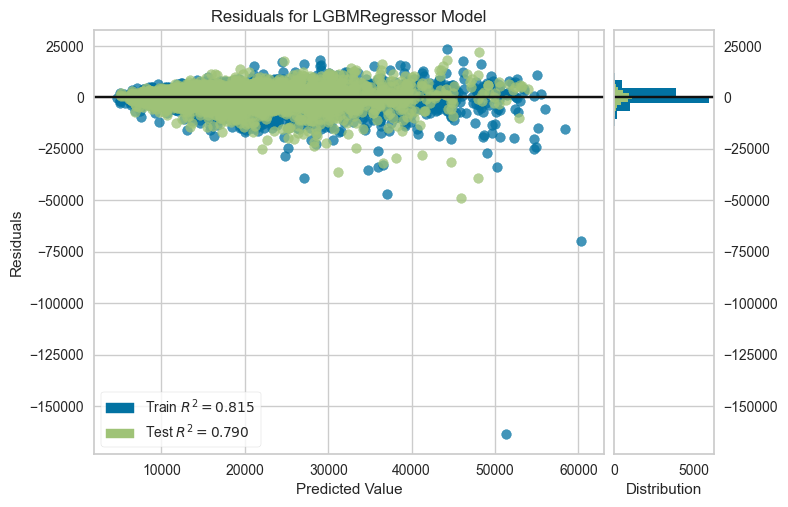

In [24]:
# Residuals plot - check for patterns (should be random)
plot_model(final_model, plot='residuals')

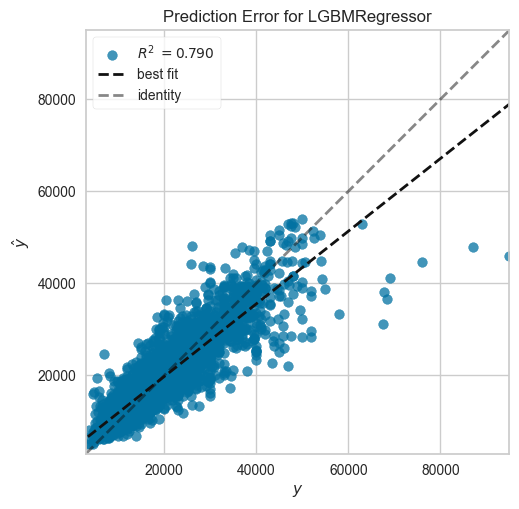

In [25]:
# Prediction error plot - predicted vs actual
plot_model(final_model, plot='error')

## 4.3 Feature Importance

Understanding which features drive predictions:
- **Decision Tree/Random Forest**: Uses feature splits
- **Gradient Boosting (XGBoost/LightGBM/CatBoost)**: Uses gain/split metrics
- **SHAP values**: Model-agnostic explanation

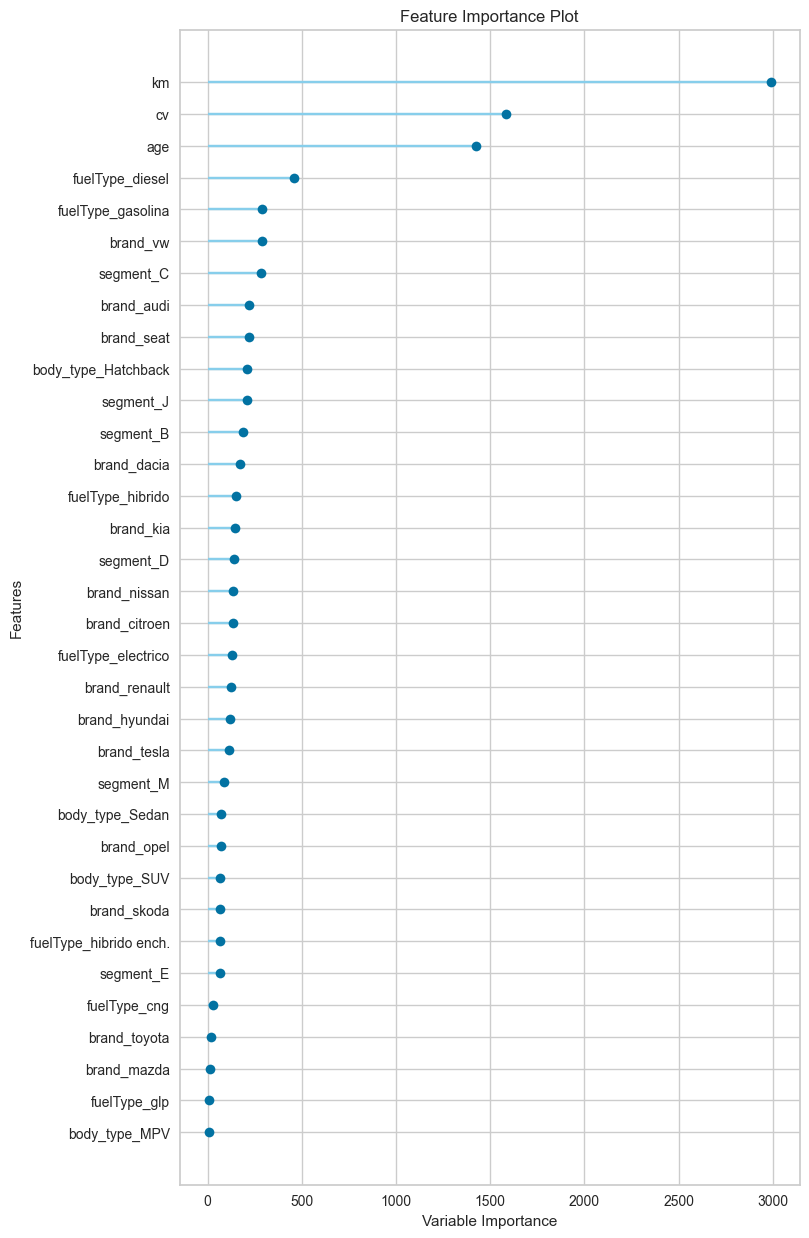

In [26]:
# Feature importance (all methods available for this model)
plot_model(final_model, plot='feature_all')

## 4.4 SHAP Analysis

**SHAP (SHapley Additive exPlanations)** provides:
- **Summary plot**: Overall feature impact across all predictions
- **Reason plot**: Explanation for individual predictions
- **Correlation**: Feature relationships with target

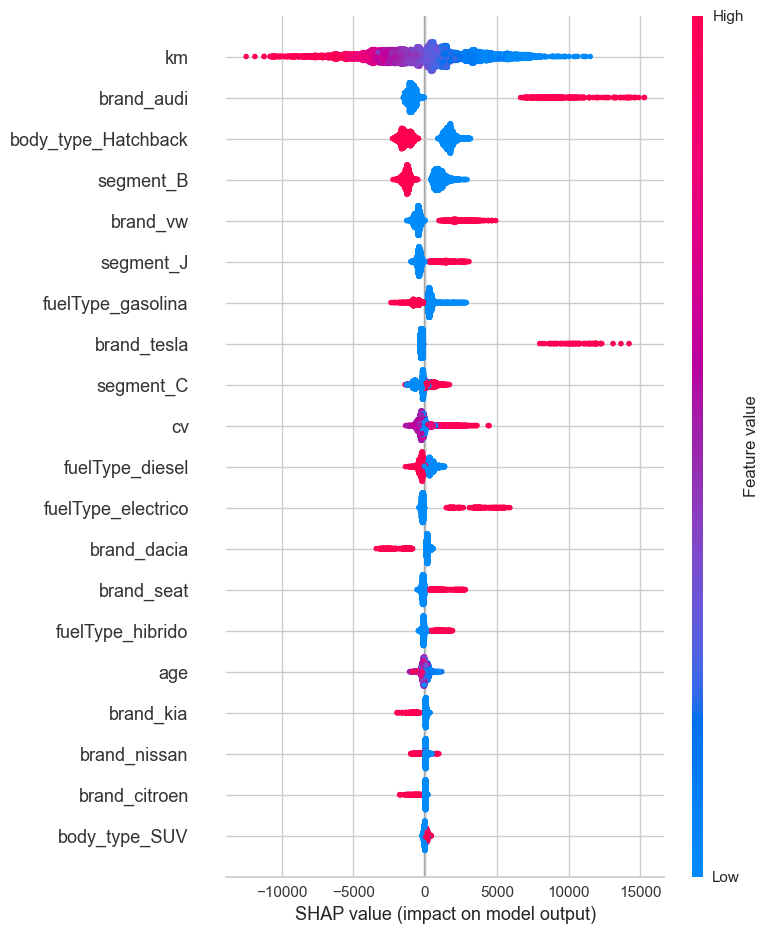

In [27]:
# SHAP summary - shows feature impact distribution
interpret_model(final_model, plot='summary')

In [28]:
# SHAP explanation for a specific test set observation
interpret_model(final_model, plot='reason', observation=1)

In [ ]:
# Predict on holdout set
holdout_pred = predict_model(final_model)
print("\nHoldout Set Predictions (first 5):")
print(holdout_pred.head())

## 4.5 Holdout Set Evaluation

Evaluate on the holdout test set before finalizing.

# 5. Finalize and Save Model

Finalize trains on the complete dataset (train + test) for deployment.

In [29]:
# Finalize model - trains on full dataset
final_auto_ml = finalize_model(final_model)
print(f"Finalized model: {type(final_auto_ml).__name__}")

Finalized model: Pipeline


In [31]:
# Save model directly to models folder
import os

models_dir = os.path.join('..', 'models')
os.makedirs(models_dir, exist_ok=True)

# Save using PyCaret's save_model function
model_name = os.path.join(models_dir, 'auto_ml_pycaret')
save_model(final_auto_ml, model_name)
print(f'Saved PyCaret model to {model_name}.pkl')

Transformation Pipeline and Model Successfully Saved
Saved PyCaret model to ..\models\auto_ml_pycaret.pkl
